In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy


torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float32
device = "cpu"

M_cutoff = 50 # maximum harmonic
N_grid   = 512
m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
#design matrix needed to sample densities
DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
std_harm = 2.0 / (1.0 + m)**2

N_train = 1500
N_test = 250
N_val = 250

N_batch = 50
N_epochs = 200
lr = 1e-3 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training

Setup the functional and sample density profiles 

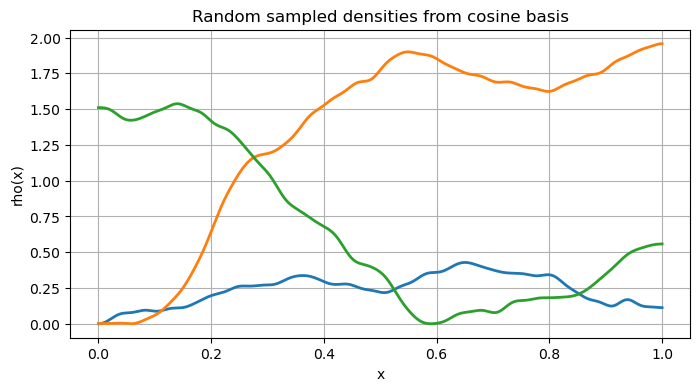

In [53]:
def sample_density(*, rho_b=0.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density is non-negative everywhere

    Returns:
      rho : (N,) density profile
    """    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix

    rho = rho - rho.min() + rho_b  # make non-negative
    return rho

def sample_density_batch(B: int, rho_b=0.0):
    """
    Sample a batch of B density profiles.
    Returns rho: (B, N_grid)
    """
    a = torch.normal(torch.zeros(B, std_harm.numel()), std_harm.expand(B, -1))
    rho = a @ DesignMatrix  # (B, N_grid)

    rho_min = rho.min(dim=1, keepdim=True).values
    rho = rho - rho_min + rho_b
    return rho

def E_tot(rho: torch.Tensor) -> torch.Tensor:
    """
    Compute E_tot -- custom functional
    rho: (N,) or (B, N)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    return (rho + rho**2).sum(dim=-1) / N_grid

# generate one sample
rho_batch = sample_density_batch(32)  # (B, N_grid)

# plot
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), rho_batch[0, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[1, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[2, :].numpy(), lw=2)
plt.xlabel("x")
plt.ylabel("rho(x)")
plt.title("Random sampled densities from cosine basis")
plt.grid(True)
plt.show()


Feature processing (generation and normalization)

In [54]:
# we save features as (B, N_grid, N_feat), where N_feat=1 for now
# generate train/test split

def compute_normalization_stats(features):
    """
    Compute mean and std for features with shape (N_data, N_grid, N_feat)
    Averages over both data and spatial dimensions
    
    Args:
        features: torch.Tensor of shape (N_data, N_grid, N_feat)
    
    Returns:
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)
    """

    mean_feat = features.mean(dim=(0, 1), keepdim=True)  # Shape: (1, 1, N_feat)
    std_feat = features.std(dim=(0, 1), keepdim=True) # Shape: (1, 1, N_feat)
    
    return mean_feat, std_feat

def normalize_features(features, mean_feat, std_feat):
    """
    Normalize features using provided or computed statistics
    
    Args:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)

    Returns:
        normalized_features: torch.Tensor of same shape as input
        mean: mean used for normalization
        std: std used for normalization
    """
    normalized_features = (features - mean_feat) / std_feat

    return normalized_features

rho_train = sample_density_batch(N_train)  # (N_train, N_grid)
rho_test  = sample_density_batch(N_test)   # (N_test, N_grid)
rho_val  = sample_density_batch(N_val)    # (N_val, N_grid)
features_train = rho_train.unsqueeze(-1)
features_test = rho_test.unsqueeze(-1)
features_val = rho_val.unsqueeze(-1)
targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,)
targets_val   = E_tot(rho_val)              # (N_val,)


# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)

In [ ]:
# Define the neural network models
class LocalEngDensityNN(nn.Module):
    """
    A neural network for predicting energy density from a local feature vector.
    """
    def __init__(self, N_feat=1, hidden_dim=128, n_hidden=2):
        super().__init__()
        layers = []
        layers.append(nn.Linear(N_feat, hidden_dim))
        layers.append(nn.GELU())
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.GELU())
        
        layers.append(nn.Linear(hidden_dim, 1))  # scalar output

        self.net = nn.Sequential(*layers)
        self.N_feat = N_feat
        self.hidden_dim = hidden_dim
        self.n_hidden = n_hidden

    def forward(self, features):
        # features: (B, N_grid, N_feat)
        output = self.net(features)
        return output.squeeze(-1)
    
class TotalEnergyNN(nn.Module):
    def __init__(self, N_feat=1, hidden_dim=128, n_hidden=2):
        super().__init__()
        self.local_energy_net = LocalEngDensityNN(N_feat, hidden_dim, n_hidden)
        self.N_feat = N_feat
        self.hidden_dim = hidden_dim
        self.n_hidden = n_hidden

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat)
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        local_energies = self.local_energy_net(features)        # (B, N_grid)
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,)
        
        return local_energies, total_energy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            _, y_pred = model(xb)
            loss = criterion(y_pred, yb)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

def load_checkpoint(path, model_class, device="cpu"):
    """
    Loads a saved model checkpoint.
    Returns:
        model: reconstructed and loaded model
        normalization: dict of normalization stats
        epoch: best epoch
        val_loss: best validation loss
    """
    ckpt = torch.load(path, map_location=device)
    config = ckpt["config"]
    model = model_class(**config).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    normalization = ckpt.get("normalization", None)
    epoch = ckpt.get("epoch", None)
    val_loss = ckpt.get("val_loss", None)
    return model, normalization, epoch, val_loss
    
def _run_epoch(model, loader, criterion, train: bool):
    if train:
        model.train()
    else:
        model.eval()
    running = 0.0
    n_batches = 0

    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            if train:
                optimizer.zero_grad()

            _, total_pred = model(xb)               
            loss = criterion(total_pred, yb)        

            if train:
                loss.backward()
                # Optional: Gradient clipping to stabilize training
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            running += loss.item()
            n_batches += 1

    return running / max(1, n_batches)

def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    max_epochs=10000,
    patience=10,
    min_delta=1e-5,
    ckpt_dir="checkpoints",
    run_name=None,
):
    os.makedirs(ckpt_dir, exist_ok=True)
    if run_name is None:
        run_name = time.strftime("run_%Y%m%d_%H%M%S")

    best_val = math.inf
    best_state = None
    best_epoch = -1
    since_improved = 0

    hist = {"train_loss": [], "val_loss": []}

    for epoch in range(1, max_epochs + 1):
        train_loss = _run_epoch(model, train_loader, criterion, train=True)
        val_loss = _run_epoch(model, val_loader, criterion, train=False)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        scheduler.step(val_loss)

        improved = (best_val - val_loss) > min_delta
        if improved:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            since_improved = 0

            # save checkpoint with normalization stats
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_best.pt")
            torch.save({
                "model_state_dict": best_state,
                "epoch": best_epoch,
                "val_loss": best_val,
                "config": {
                    "N_feat": model.N_feat,
                    "hidden_dim": model.hidden_dim,
                    "n_hidden": model.n_hidden,
                },
                "normalization": {
                    "mean_feat": mean_feat.cpu(),
                    "std_feat":  std_feat.cpu(),
                    "E_mean":    E_mean.cpu(),
                    "E_std":     E_std.cpu(),
                    "N_grid":    int(N_grid),
                }
            }, ckpt_path)
        else:
            since_improved += 1

        if (epoch % 10) == 0 or epoch == 1:
            print(f"[{epoch:04d}] train={train_loss:.6f} | val={val_loss:.6f} "
                  f"| best_val={best_val:.6f} (epoch {best_epoch})")

        if since_improved >= patience:
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch}).")
            break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    csv_path = os.path.join(ckpt_dir, f"{run_name}_history.csv")
    try:
        import csv
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["epoch", "train_loss", "val_loss"])
            for i, (tr, va) in enumerate(zip(hist["train_loss"], hist["val_loss"]), start=1):
                w.writerow([i, tr, va])
    except Exception as e:
        print(f"[warn] could not write CSV: {e}")

    return hist, best_epoch


num_nodes_per_layer_list = [20, 40, 80, 160, 320]
num_hidden_layers_list = [2, 4, 6, 8]

for hidden_dim in num_nodes_per_layer_list:
    for n_hidden in num_hidden_layers_list:
        run_name = f"locNN_h{hidden_dim}_nh{n_hidden}"
        torch.manual_seed(1234) # for reproducibility
        # Training with early stopping and model checkpointing
        model = TotalEnergyNN(N_feat=1, hidden_dim=hidden_dim, n_hidden=n_hidden).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Reduce LR when val loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
        )

        hist, best_epoch = train_with_early_stopping(
            model,
            train_loader,
            val_loader,
            criterion,
            scheduler=scheduler,
            max_epochs=N_epochs,
            patience=patience,
            min_delta=min_delta,
            ckpt_dir="checkpoints",
            run_name=run_name,
        )
    


[0001] train=0.921283 | val=0.814447 | best_val=0.814447 (epoch 1)
[0010] train=0.010282 | val=0.011362 | best_val=0.011362 (epoch 10)
[0020] train=0.003968 | val=0.005632 | best_val=0.005632 (epoch 20)
[0030] train=0.001946 | val=0.003571 | best_val=0.003580 (epoch 29)
[0040] train=0.001285 | val=0.002519 | best_val=0.002519 (epoch 40)
[0050] train=0.000823 | val=0.001887 | best_val=0.001887 (epoch 50)
[0060] train=0.000566 | val=0.001433 | best_val=0.001433 (epoch 60)
[0070] train=0.000415 | val=0.001080 | best_val=0.001080 (epoch 70)
[0080] train=0.000317 | val=0.000911 | best_val=0.000911 (epoch 80)
[0090] train=0.000229 | val=0.000812 | best_val=0.000753 (epoch 89)
[0100] train=0.000233 | val=0.000651 | best_val=0.000649 (epoch 97)
[0110] train=0.000223 | val=0.000569 | best_val=0.000515 (epoch 108)
[0120] train=0.000124 | val=0.000448 | best_val=0.000456 (epoch 115)
[0130] train=0.000117 | val=0.000380 | best_val=0.000368 (epoch 129)
[0140] train=0.000118 | val=0.000345 | best_va

In [58]:
best_val = math.inf
best_hdim = 0
best_nhidden = 0

for hidden_dim in num_nodes_per_layer_list:
    for n_hidden in num_hidden_layers_list:
        run_name = f"locNN_h{hidden_dim}_nh{n_hidden}"

        model, normalization, epoch, val_loss = load_checkpoint(f"checkpoints/{run_name}_best.pt", TotalEnergyNN, device=device)

        print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
        if val_loss < best_val:
            best_val = val_loss
            best_hdim = hidden_dim
            best_nhidden = n_hidden

print(f"Best model: hidden_dim={best_hdim}, n_hidden={best_nhidden}, val_loss={best_val:.6f}")

Model locNN_h20_nh2: best val loss = 0.000103 at epoch 198
Model locNN_h20_nh4: best val loss = 0.000066 at epoch 145
Model locNN_h20_nh6: best val loss = 0.000076 at epoch 140
Model locNN_h20_nh8: best val loss = 0.000039 at epoch 176
Model locNN_h40_nh2: best val loss = 0.000049 at epoch 183
Model locNN_h40_nh4: best val loss = 0.000036 at epoch 120
Model locNN_h40_nh6: best val loss = 0.000021 at epoch 153
Model locNN_h40_nh8: best val loss = 0.000069 at epoch 115
Model locNN_h80_nh2: best val loss = 0.000033 at epoch 130
Model locNN_h80_nh4: best val loss = 0.000028 at epoch 92
Model locNN_h80_nh6: best val loss = 0.000083 at epoch 79
Model locNN_h80_nh8: best val loss = 0.000178 at epoch 63
Model locNN_h160_nh2: best val loss = 0.000026 at epoch 105
Model locNN_h160_nh4: best val loss = 0.000044 at epoch 55
Model locNN_h160_nh6: best val loss = 0.000093 at epoch 82
Model locNN_h160_nh8: best val loss = 0.000057 at epoch 102
Model locNN_h320_nh2: best val loss = 0.000018 at epoch 8

   epoch  train_loss  val_loss
0      1    0.694962  0.408863
1      2    0.178720  0.024676
2      3    0.016498  0.014078
3      4    0.009702  0.009969
4      5    0.007215  0.008516


<Axes: title={'center': 'locNN_h40_nh2'}, xlabel='epoch'>

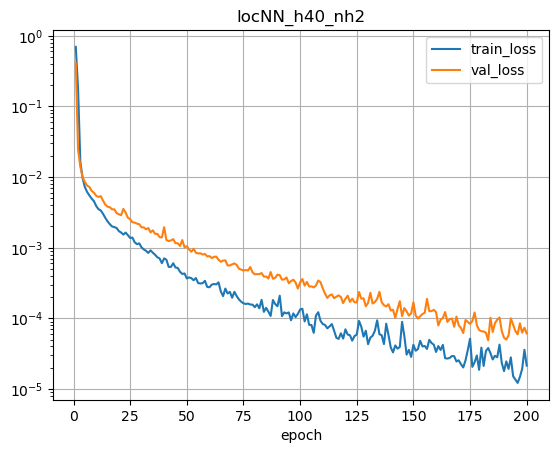

In [ ]:
import pandas as pd

hidden_dim = best_hdim
n_hidden = best_nhidden
run_name = f"locNN_h{hidden_dim}_nh{n_hidden}"
path = f"checkpoints/{run_name}_history.csv"

hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)


Evaluate performance of training

Loaded model from epoch 183 with val_loss=0.000049
Test RMSE: 3.001275e-03
Test RMSE (physical units): 0.002707


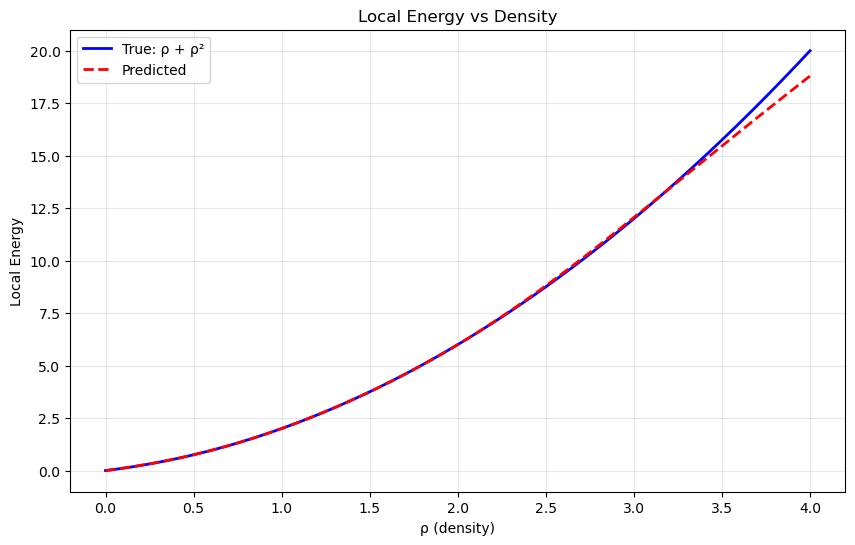

In [65]:
hidden_dim = 40 #best_hdim
n_hidden = best_nhidden
run_name = f"locNN_h{hidden_dim}_nh{n_hidden}"
best_path = f"checkpoints/{run_name}_best.pt"

model, normalization, epoch, val_loss = load_checkpoint(best_path, TotalEnergyNN, device=device)
mean_feat = normalization["mean_feat"].to(device)
std_feat  = normalization["std_feat"].to(device)
E_mean    = normalization["E_mean"].to(device)
E_std     = normalization["E_std"].to(device)
N_grid    = normalization["N_grid"]

print(f"Loaded model from epoch {epoch} with val_loss={val_loss:.6f}")
test_loss = evaluate(model, test_loader, nn.MSELoss())
test_rmse_physical = (test_loss**0.5) * E_std
print(f"Test RMSE: {test_loss**0.5:.6e}")
print(f"Test RMSE (physical units): {test_rmse_physical.item():.6f}")


rho_test = 4 * x.unsqueeze(-1).unsqueeze(0)  # (1, N_grid, 1)
loc_energy_dens = rho_test + rho_test**2

local_pred, total_pred = model(normalize_features(rho_test, mean_feat, std_feat))

# Plotting
rho_values = rho_test.squeeze().detach().numpy()  # (N_grid,)
true_local = loc_energy_dens.squeeze().detach().numpy()  # (N_grid,)
pred_local = local_pred.squeeze().detach().numpy()  # (N_grid,)

plt.figure(figsize=(10, 6))
plt.plot(rho_values, true_local, 'b-', linewidth=2, label='True: ρ + ρ²')
plt.plot(rho_values, pred_local * E_std.item() + E_mean.item(), 'r--', linewidth=2, label='Predicted')
plt.xlabel('ρ (density)')
plt.ylabel('Local Energy')
plt.title('Local Energy vs Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
